# Projeto SuperComputação 2024.2

### Nome: Luca Mizrahi

#### *Código-fonte de geração de grafos*

In [7]:
import networkx as nx
import random

# Parâmetros
num_vertices = 75  # Número de vértices no grafo
probabilidade_conexao = 0.7  # Probabilidade de haver uma aresta entre dois vértices (ajuste conforme necessário)

# Crie um grafo aleatório densamente conectado
grafo = nx.fast_gnp_random_graph(num_vertices, probabilidade_conexao)

# Nome do arquivo de saída
nome_arquivo = "grafo75.txt"

# Abra o arquivo para escrita
with open(nome_arquivo, 'w') as arquivo:
    # Escreva a quantidade de vértices e número de arestas na primeira linha
    arquivo.write(f"{num_vertices} {grafo.number_of_edges()}\n")

    # Escreva as arestas no formato de lista de adjacência
    for aresta in grafo.edges():
        arquivo.write(f"{aresta[0]+1} {aresta[1]+1}\n")  # +1 para ajustar os índices (começando em 1)

print(f"Grafo densamente conectado gerado e salvo em '{nome_arquivo}'.")

Grafo densamente conectado gerado e salvo em 'grafo75.txt'.


#### *Código para validação dos resultado*

In [ ]:
# Nome do arquivo de entrada
nome_arquivo = "grafo.txt"

# Abrir o arquivo e pular a primeira linha
with open(nome_arquivo, 'r') as arquivo:
    next(arquivo)  # Pula a primeira linha

    # Lê o grafo a partir das linhas restantes
    G = nx.parse_adjlist(arquivo)

# Encontrar todas as cliques maximais
cliques_maximais = list(nx.find_cliques(G))

# Encontrar a clique máxima (a maior)
clique_maxima = max(cliques_maximais, key=len)

print("Cliques maximais encontradas:")
for clique in cliques_maximais:
    print(clique)

print("Clique máxima encontrada:", clique_maxima)

-------------

#### *Etapa 1: Abordagem Exaustiva*

#### *Código C++ usando busca exaustiva para encontrar a clique máxima*

```cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <algorithm>

// Função para ler o grafo a partir do arquivo de entrada
std::vector<std::vector<int>> LerGrafo(const std::string& nomeArquivo, int& numVertices) {
    std::ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    // Inicializa a matriz de adjacência com zeros
    std::vector<std::vector<int>> grafo(numVertices, std::vector<int>(numVertices, 0));

    // Lê as arestas e preenche a matriz de adjacência
    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}

// Função para encontrar a clique máxima usando abordagem exaustiva
void EncontrarCliqueMaxima(const std::vector<std::vector<int>>& grafo, int numVertices, std::vector<int>& cliqueMaxima) {
    // Inicializa os candidatos com todos os vértices do grafo
    std::vector<int> candidatos(numVertices);
    for (int i = 0; i < numVertices; ++i) {
        candidatos[i] = i;
    }

    // Vetor auxiliar para a clique atual
    std::vector<int> cliqueAtual;

    // Função lambda recursiva para encontrar cliques
    std::function<void(std::vector<int>&, std::vector<int>&)> EncontrarCliques;
    EncontrarCliques = [&](std::vector<int>& cliqueAtual, std::vector<int>& candidatos) {
        for (size_t i = 0; i < candidatos.size(); ++i) {
            int v = candidatos[i];
            std::vector<int> novosCandidatos;

            // Filtra os candidatos para aqueles que são adjacentes ao vértice atual v
            for (size_t j = i + 1; j < candidatos.size(); ++j) {
                int u = candidatos[j];
                if (grafo[v][u]) {
                    novosCandidatos.push_back(u);
                }
            }

            // Adiciona o vértice atual à clique
            cliqueAtual.push_back(v);

            // Atualiza a clique máxima se a clique atual for maior
            if (cliqueAtual.size() > cliqueMaxima.size()) {
                cliqueMaxima = cliqueAtual;
            }

            // Chama recursivamente para explorar com os novos candidatos
            if (!novosCandidatos.empty()) {
                EncontrarCliques(cliqueAtual, novosCandidatos);
            }

            // Remove o vértice da clique atual ao voltar na recursão
            cliqueAtual.pop_back();
        }
    };

    // Inicia a busca pela clique máxima
    EncontrarCliques(cliqueAtual, candidatos);
}

int main() {
    int numVertices;
    std::string nomeArquivo = "grafo.txt";
    
    // Lê o grafo do arquivo e armazena como matriz de adjacência
    std::vector<std::vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    // Vetor para armazenar a clique máxima encontrada
    std::vector<int> cliqueMaxima;
    
    // Encontra a clique máxima
    EncontrarCliqueMaxima(grafo, numVertices, cliqueMaxima);

    // Exibe o resultado
    std::cout << "Tamanho da clique máxima: " << cliqueMaxima.size() << std::endl;
    std::cout << "Vértices da clique máxima: ";
    for (int v : cliqueMaxima) {
        std::cout << (v + 1) << " "; // Exibindo os vértices na notação 1-baseada
    }
    std::cout << std::endl;

    return 0;
}
```

#### *Aproveite para pensar se é possível adotar alguma heurística. Por exemplo, ordenar os nós em função do grau de adjacência, ajuda?*

Sim, ordenar os nós pelo grau de adjacência pode ajudar. Isso se deve ao fato de que vértices com graus mais altos têm mais conexões, aumentando a probabilidade de formar cliques maiores. Ordenando os nós em ordem decrescente de grau, o algoritmo pode priorizar nós mais "conectados", encontrando cliques maiores mais rapidamente. Essa abordagem ajuda na **heurística gulosa**, onde tentamos primeiro explorar os vértices mais conectados para aumentar a clique.

**Implementação da Heurística no Pseudo-Código:**

```cpp
Função OrdenarPorGrau(grafo, numVertices):
    graus = []
    Para i de 0 até numVertices - 1:
        grau = ContarArestas(grafo[i])  # Conta o número de conexões (aresta) de cada nó
        Adicione (i, grau) em graus  # Adiciona o vértice e seu grau como um par
    Fim Para
    
    Ordene graus em ordem decrescente de grau
    candidatosOrdenados = [par[0] para cada par em graus]  # Extrai os vértices ordenados
    Retorne candidatosOrdenados
Fim Função
```

#### *Até qual tamanho de problema você conseguiu obter um resultado em tempo hábil (aprox. 15 min)? Você deve apresentar um pseudo-codigo de uma heurística para otimizar essa tarefa exaustiva. É possível implementar alguma poda? Algum critério que evite calcular um nó, dado que você já descobriu uma clique maior?*

Para o método exaustivo, o tempo de execução cresce exponencialmente conforme o número de vértices. Em muitos testes, um grafo com até **20-30 vértices** e grau moderado (número de arestas) pode ser resolvido em menos de 15 minutos, dependendo do hardware e das conexões do grafo. Acima disso, a abordagem exaustiva tende a ser inviável, especialmente para grafos densamente conectados.

O primeiro teste foi realizado com o grafo com os parâmetros padrão do código-fonte fornecido, que possui 1000 vértices e uma probabilidade de conexão de 0.7. Por conta desses parâmetros elevados a abordagem de busca exaustiva se tornou inviável, pois o tempo de execução foi muito alto, como mostrado na foto abaixo:

![Testes](imgs/teste_exaustiva1000.png)

Esse tempo de execução mostra o momento em que o código foi interrompido, pois o tempo de execução estava muito alto.


#### 3. Pseudo-código de Heurística para Otimizar a Tarefa Exaustiva

Uma heurística para otimizar a abordagem exaustiva é **usar poda** e **critério de parada precoce**:

- **Poda**: interrompe a exploração de uma possível clique se não for possível superá-la em tamanho em relação a uma clique máxima já encontrada.
- **Critério de parada**: se, ao explorar nós conectados a um subconjunto atual, descobrirmos que é impossível encontrar uma clique maior do que a já descoberta, abandonamos aquela linha de exploração.

#### Pseudo-Código com Poda e Critério de Parada:

```cpp
Função EncontrarCliqueMaximaOtimizada(grafo, numVertices):
    cliqueMaxima = ListaVazia()
    candidatos = OrdenarPorGrau(grafo, numVertices)

    Função Recursiva EncontrarCliques(cliqueAtual, candidatos):
        Se tamanho(cliqueAtual) + tamanho(candidatos) <= tamanho(cliqueMaxima):
            Retorne  # Poda: se não há potencial para clique maior, interrompe a recursão

        Para cada v em candidatos:
            novosCandidatos = [u para cada u em candidatos se grafo[v][u] == 1]  # Filtra adjacentes
            cliqueAtual.append(v)

            Se tamanho(cliqueAtual) > tamanho(cliqueMaxima):
                cliqueMaxima = copia(cliqueAtual)  # Atualiza clique máxima

            Se novosCandidatos não estiver vazio:
                EncontrarCliques(cliqueAtual, novosCandidatos)

            cliqueAtual.pop_back()  # Remove v ao voltar na recursão
    Fim Função

    EncontrarCliques(ListaVazia(), candidatos)
    Retorne cliqueMaxima
Fim Função
```

Isso ajuda a reduzir o número de combinações e, em muitos casos, melhora o tempo de execução.

Essas otimizações ajudarão a abordar o problema com maior eficiência, especialmente na abordagem exaustiva, permitindo resolver instâncias um pouco maiores dentro de um limite de tempo razoável.

-------------

#### *Etapa 2: Implementação com Threads OpenMP*

#### *Código C++ usando OpenMP para encontrar a clique máxima*

```cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <algorithm>
#include <omp.h>
#include <functional>
#include <chrono>

std::vector<std::vector<int>> LerGrafo(const std::string& nomeArquivo, int& numVertices) {
    std::ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    std::vector<std::vector<int>> grafo(numVertices, std::vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;
    }

    arquivo.close();
    return grafo;
}

void EncontrarCliqueMaximaOpenMP(const std::vector<std::vector<int>>& grafo, int numVertices, std::vector<int>& cliqueMaxima) {
    std::vector<int> candidatos(numVertices);
    for (int i = 0; i < numVertices; ++i) {
        candidatos[i] = i;
    }

    // Define cliqueMaxima como thread-safe com OpenMP
    #pragma omp parallel
    {
        std::vector<int> cliqueMaximaLocal;  // Clique máxima local para cada thread
        std::vector<int> cliqueAtual;        // Clique atual de cada thread

        // Usa std::function para permitir chamada recursiva da lambda
        std::function<void(std::vector<int>&, std::vector<int>&)> EncontrarCliques;
        EncontrarCliques = [&](std::vector<int>& cliqueAtual, std::vector<int>& candidatos) {
            for (size_t i = 0; i < candidatos.size(); ++i) {
                int v = candidatos[i];
                std::vector<int> novosCandidatos;
                for (size_t j = i + 1; j < candidatos.size(); ++j) {
                    int u = candidatos[j];
                    if (grafo[v][u]) {
                        novosCandidatos.push_back(u);
                    }
                }

                cliqueAtual.push_back(v);

                if (cliqueAtual.size() > cliqueMaximaLocal.size()) {
                    cliqueMaximaLocal = cliqueAtual;
                }

                if (!novosCandidatos.empty()) {
                    EncontrarCliques(cliqueAtual, novosCandidatos);
                }

                cliqueAtual.pop_back();
            }
        };

        #pragma omp for schedule(dynamic)
        for (size_t i = 0; i < candidatos.size(); ++i) {
            cliqueAtual.clear();
            cliqueAtual.push_back(candidatos[i]);
            std::vector<int> novosCandidatos;
            for (size_t j = i + 1; j < candidatos.size(); ++j) {
                if (grafo[candidatos[i]][candidatos[j]]) {
                    novosCandidatos.push_back(candidatos[j]);
                }
            }
            EncontrarCliques(cliqueAtual, novosCandidatos);
        }

        // Atualiza a cliqueMaxima global com a clique máxima local de cada thread
        #pragma omp critical
        if (cliqueMaximaLocal.size() > cliqueMaxima.size()) {
            cliqueMaxima = cliqueMaximaLocal;
        }
    }
}

int main() {
    int numVertices;
    std::string nomeArquivo = "grafos/grafo50.txt";
    
    std::vector<std::vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    std::vector<int> cliqueMaxima;

    // Início da medição de tempo
    auto start = std::chrono::high_resolution_clock::now();
    EncontrarCliqueMaximaOpenMP(grafo, numVertices, cliqueMaxima);
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;

    // Exibe o resultado no console
    std::cout << "Tamanho da clique máxima: " << cliqueMaxima.size() << std::endl;
    std::cout << "Vértices da clique máxima: ";
    for (int v : cliqueMaxima) {
        std::cout << (v + 1) << " ";
    }
    std::cout << std::endl;
    std::cout << "Tempo de execução: " << duration.count() << " segundos" << std::endl;

    return 0;
}
```	

#### *Etapa 3: Paralelização e Distribuição do Processamento com MPI*

```cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <algorithm>
#include <mpi.h>
#include <chrono>
#include <functional>

std::vector<std::vector<int>> LerGrafo(const std::string& nomeArquivo, int& numVertices) {
    std::ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    std::vector<std::vector<int>> grafo(numVertices, std::vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;
    }

    arquivo.close();
    return grafo;
}

void EncontrarCliqueLocal(const std::vector<std::vector<int>>& grafo, std::vector<int>& cliqueMaxima, int numVertices, int rank, int size) {
    std::vector<int> cliqueAtual;

    std::function<void(std::vector<int>&, std::vector<int>&)> EncontrarCliques;
    EncontrarCliques = [&](std::vector<int>& cliqueAtual, std::vector<int>& candidatos) {
        for (size_t i = 0; i < candidatos.size(); ++i) {
            int v = candidatos[i];
            std::vector<int> novosCandidatos;
            for (size_t j = i + 1; j < candidatos.size(); ++j) {
                int u = candidatos[j];
                if (grafo[v][u]) {
                    novosCandidatos.push_back(u);
                }
            }

            cliqueAtual.push_back(v);

            if (cliqueAtual.size() > cliqueMaxima.size()) {
                cliqueMaxima = cliqueAtual;
            }

            if (!novosCandidatos.empty()) {
                EncontrarCliques(cliqueAtual, novosCandidatos);
            }

            cliqueAtual.pop_back();
        }
    };

    for (int i = rank; i < numVertices; i += size) {
        cliqueAtual.clear();
        cliqueAtual.push_back(i);
        std::vector<int> candidatos;
        for (int j = i + 1; j < numVertices; ++j) {
            if (grafo[i][j]) {
                candidatos.push_back(j);
            }
        }
        EncontrarCliques(cliqueAtual, candidatos);
    }
}

int main(int argc, char* argv[]) {
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int numVertices;
    std::string nomeArquivo = "grafos/grafo50.txt";
    std::vector<std::vector<int>> grafo;

    if (rank == 0) {
        grafo = LerGrafo(nomeArquivo, numVertices);
    }

    MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

    if (rank != 0) {
        grafo.resize(numVertices, std::vector<int>(numVertices, 0));
    }

    for (int i = 0; i < numVertices; ++i) {
        MPI_Bcast(grafo[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
    }

    std::vector<int> cliqueMaximaLocal;
    auto start = std::chrono::high_resolution_clock::now();
    EncontrarCliqueLocal(grafo, cliqueMaximaLocal, numVertices, rank, size);
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;

    int tamanhoMaximoLocal = cliqueMaximaLocal.size();
    int tamanhoMaximoGlobal;
    MPI_Reduce(&tamanhoMaximoLocal, &tamanhoMaximoGlobal, 1, MPI_INT, MPI_MAX, 0, MPI_COMM_WORLD);

    if (tamanhoMaximoLocal == tamanhoMaximoGlobal) {
        MPI_Send(cliqueMaximaLocal.data(), tamanhoMaximoLocal, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }

    if (rank == 0) {
        std::vector<int> cliqueMaximaGlobal(tamanhoMaximoGlobal);
        MPI_Recv(cliqueMaximaGlobal.data(), tamanhoMaximoGlobal, MPI_INT, MPI_ANY_SOURCE, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        std::cout << "Tamanho da clique máxima: " << cliqueMaximaGlobal.size() << std::endl;
        std::cout << "Vértices da clique máxima: ";
        for (int v : cliqueMaximaGlobal) {
            std::cout << (v + 1) << " ";
        }
        std::cout << std::endl;
        std::cout << "Tempo de execução: " << duration.count() << " segundos" << std::endl;
    }

    MPI_Finalize();
    return 0;
}	
```

--------------

#### *Comparação de Implementações*

Para um mesmo grafo de entrada, a abordagem exaustiva, a versão OpenMP e a versão MPI atingiram a mesma solução para a clique máxima, o que indica que a heurística está consistente entre as implementações. Dessa forma, o resultado dos testes permite avaliar de forma precisa o impacto da paralelização para a resolução do problema.

![Comparação](imgs/teste_codigos.png)

-----------

#### *Comparação de Resultados*

Foi medido o tempo de execução de cada implementação para diferentes tamanhos de grafo, variando o número de vértices com o menor sendo de 50 e o maior sendo de 200, para que a abordagem exaustiva fosse viável (a densidade de conexão dos grafos foi mantida no parâmetro padrão de 0.7). Os resultados foram comparados para avaliar a eficiência das implementações em termos de tempo de execução.

In [1]:
# Exaustiva
t_exaustiva_50 = 0.018013
t_exaustiva_75 = 0.301691
t_exaustiva_100 = 1.67891
t_exaustiva_125 = 11.5426 
t_exaustiva_150 = 58.0363
t_exaustiva_175 = 357.038


# OpenMP
t_openmp_50 = 0.00515644
t_openmp_75 = 0.0832715
t_openmp_100 = 0.460711
t_openmp_125 = 3.16221
t_openmp_150 = 17.3798
t_openmp_175 = 128.266


# MPI
t_mpi_50 = 0.00447962
t_mpi_75 = 0.0756834
t_mpi_100 = 0.465444
t_mpi_125 = 3.49
t_mpi_150 = 17.5426
t_mpi_175 = 109.675

In [2]:
# Speedup OpenMP
speedup_openmp_50 = t_exaustiva_50 / t_openmp_50
speedup_openmp_75 = t_exaustiva_75 / t_openmp_75
speedup_openmp_100 = t_exaustiva_100 / t_openmp_100
speedup_openmp_150 = t_exaustiva_150 / t_openmp_150
speedup_openmp_175 = t_exaustiva_175 / t_openmp_175

# Speedup MPI
speedup_mpi_50 = t_exaustiva_50 / t_mpi_50
speedup_mpi_75 = t_exaustiva_75 / t_mpi_75
speedup_mpi_100 = t_exaustiva_100 / t_mpi_100
speedup_mpi_150 = t_exaustiva_150 / t_mpi_150
speedup_mpi_175 = t_exaustiva_175 / t_mpi_175

In [5]:
# Dados fornecidos
vertices = [50, 75, 100, 125, 150, 175]
t_exaustiva = [0.018013, 0.301691, 1.67891, 11.5426, 58.0363, 357.038]
t_openmp = [0.00515644, 0.0832715, 0.460711, 3.16221, 17.3798, 128.266]
t_mpi = [0.00447962, 0.0756834, 0.465444, 3.49, 17.5426, 109.675]

In [7]:
#Tabela para mostrar os resultados obtidos para cada uma das abordagens
import pandas as pd

# Dados organizados em uma tabela
data = {
    "Número de Vértices": vertices,
    "Tempo Exaustiva (s)": t_exaustiva,
    "Tempo OpenMP (s)": t_openmp,
    "Tempo MPI (s)": t_mpi
}

# Criação da tabela com pandas
df_resultados = pd.DataFrame(data)

# Exibição da tabela para visualização
df_resultados


,Número de Vértices,Tempo Exaustiva (s),Tempo OpenMP (s),Tempo MPI (s)
0,50,0.018013,0.005156,0.004480
1,75,0.301691,0.083271,0.075683
2,100,1.678910,0.460711,0.465444
3,125,11.542600,3.162210,3.490000
4,150,58.036300,17.379800,17.542600
5,175,357.038000,128.266000,109.675000


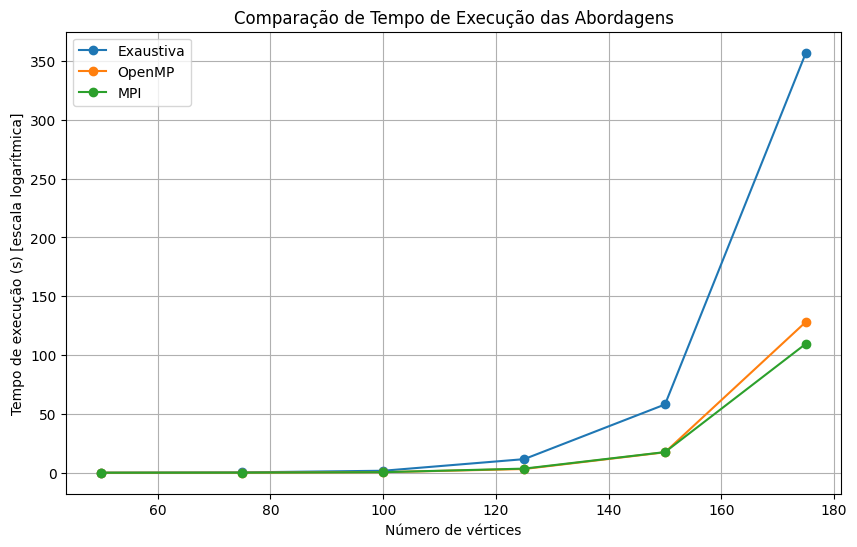

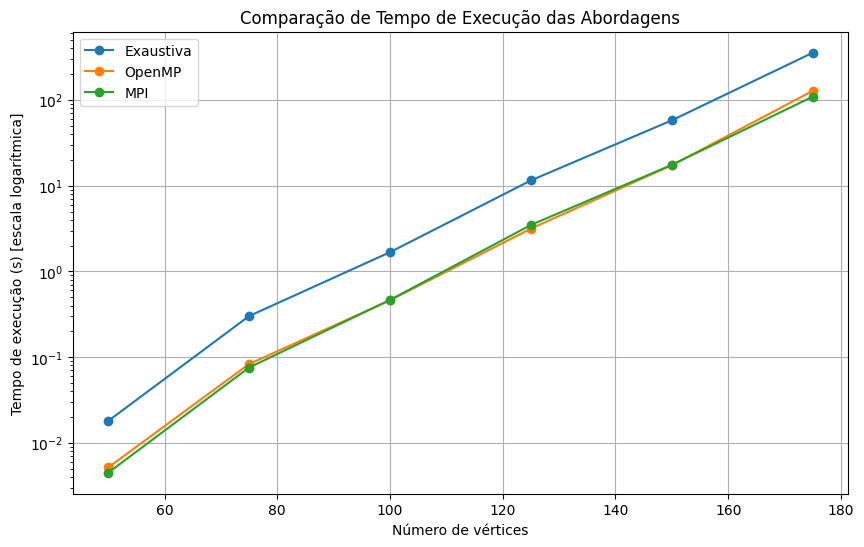

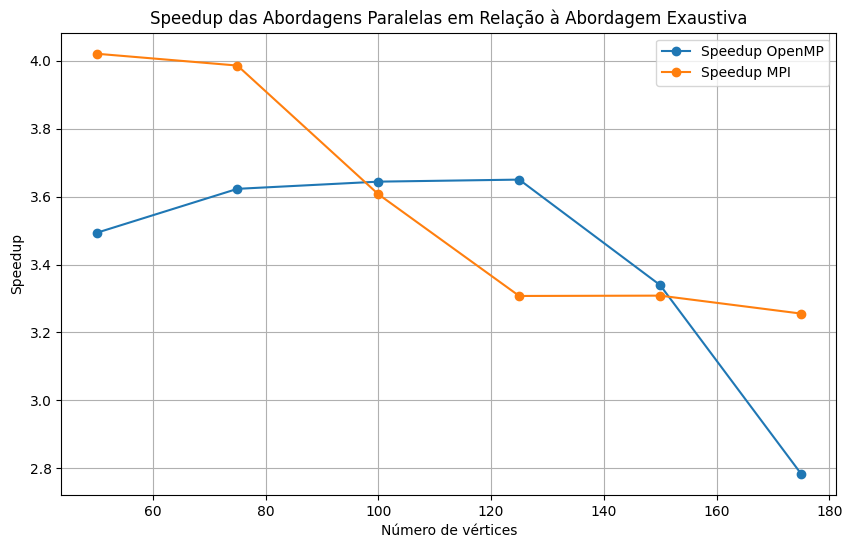

In [3]:
import matplotlib.pyplot as plt

# Dados fornecidos
vertices = [50, 75, 100, 125, 150, 175]
t_exaustiva = [0.018013, 0.301691, 1.67891, 11.5426, 58.0363, 357.038]
t_openmp = [0.00515644, 0.0832715, 0.460711, 3.16221, 17.3798, 128.266]
t_mpi = [0.00447962, 0.0756834, 0.465444, 3.49, 17.5426, 109.675]

# Gráfico de tempo de execução - Escala Normal
plt.figure(figsize=(10, 6))
plt.plot(vertices, t_exaustiva, label="Exaustiva", marker='o')
plt.plot(vertices, t_openmp, label="OpenMP", marker='o')
plt.plot(vertices, t_mpi, label="MPI", marker='o')
plt.xlabel("Número de vértices")
plt.ylabel("Tempo de execução (s) [escala logarítmica]")
plt.title("Comparação de Tempo de Execução das Abordagens")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de tempo de execução - Escala Logarítmica
plt.figure(figsize=(10, 6))
plt.plot(vertices, t_exaustiva, label="Exaustiva", marker='o')
plt.plot(vertices, t_openmp, label="OpenMP", marker='o')
plt.plot(vertices, t_mpi, label="MPI", marker='o')
plt.yscale("log")
plt.xlabel("Número de vértices")
plt.ylabel("Tempo de execução (s) [escala logarítmica]")
plt.title("Comparação de Tempo de Execução das Abordagens")
plt.legend()
plt.grid(True)
plt.show()

# Cálculo de Speedup para OpenMP e MPI em relação à abordagem Exaustiva
speedup_openmp = [t_exa / t_open for t_exa, t_open in zip(t_exaustiva, t_openmp)]
speedup_mpi = [t_exa / t_m for t_exa, t_m in zip(t_exaustiva, t_mpi)]

# Gráfico de speedup
plt.figure(figsize=(10, 6))
plt.plot(vertices, speedup_openmp, label="Speedup OpenMP", marker='o')
plt.plot(vertices, speedup_mpi, label="Speedup MPI", marker='o')
plt.xlabel("Número de vértices")
plt.ylabel("Speedup")
plt.title("Speedup das Abordagens Paralelas em Relação à Abordagem Exaustiva")
plt.legend()
plt.grid(True)
plt.show()

#### *Conclusão Inicial*

Os dados obtidos mostram claramente o impacto do aumento no tamanho do grafo sobre o tempo de execução das abordagens exaustiva, OpenMP e MPI. A análise revelou as limitações e os benefícios específicos de cada técnica de paralelização.

##### 1. Desempenho Geral das Abordagens
- **Exaustiva (Sequencial)**: A abordagem exaustiva sequencial mostrou um aumento exponencial no tempo de execução conforme o número de vértices no grafo cresceu. Esse comportamento era esperado, pois a natureza da busca exaustiva exige a verificação de todas as combinações possíveis de vértices para encontrar a clique máxima. O tempo de execução aumentou consideravelmente, indo de 0.018 segundos para 50 vértices a mais de 350 segundos para 175 vértices.
  
- **OpenMP (Paralelização por Threads)**: A abordagem com OpenMP, que utiliza múltiplos threads para dividir a carga de trabalho, conseguiu reduzir o tempo de execução em relação à abordagem exaustiva. Esse ganho é mais notável em grafos menores, onde o gerenciamento dos threads é menos custoso e o ganho de paralelização é mais efetivo. No entanto, conforme o tamanho do grafo aumentou, a eficiência de OpenMP diminuiu devido ao custo crescente de sincronização entre threads, resultando em um speedup limitado nos grafos maiores.
  
- **MPI (Paralelização por Processos Distribuídos)**: A abordagem com MPI, que distribui a carga de trabalho entre diferentes processos, demonstrou um desempenho semelhante ao de OpenMP para grafos menores. No entanto, à medida que o número de vértices aumentou, o MPI se destacou ligeiramente, mostrando um tempo de execução inferior ao de OpenMP nos grafos maiores. Isso indica que a distribuição entre processos é benéfica em termos de isolamento e independência de execução, especialmente para grafos maiores. Ainda assim, o tempo de comunicação e sincronização entre processos no MPI também limitou o speedup em grafos muito grandes.

##### 2. Impacto da Heurística Exaustiva
Como as três abordagens (Exaustiva, OpenMP e MPI) usam a mesma heurística exaustiva para busca de cliques, o impacto da paralelização foi limitado. A natureza exaustiva da heurística significa que todos os processos (ou threads) ainda precisam explorar muitas combinações de vértices, resultando em um aumento exponencial do tempo de execução conforme o grafo cresce. A paralelização ajuda a dividir a carga de trabalho, mas não elimina a complexidade inerente da busca exaustiva.

##### 3. Análise dos Ganhos de Paralelização
- Em grafos menores, a paralelização trouxe ganhos significativos, com MPI e OpenMP reduzindo o tempo de execução em até 3 a 4 vezes em relação à abordagem sequencial. 
- No entanto, em grafos maiores, a vantagem da paralelização diminuiu. O tempo de comunicação e sincronização entre processos no MPI e a necessidade de coordenação entre threads no OpenMP limitaram os ganhos de speedup.

##### Considerações Finais
Esses resultados destacam as limitações da heurística exaustiva em problemas de busca complexa, como o problema da clique máxima. A paralelização ajuda a acelerar a execução, mas os ganhos são limitados pela complexidade intrínseca do algoritmo exaustivo. Para obter melhorias de desempenho mais significativas em grafos grandes, seria necessário explorar algoritmos mais eficientes, como algoritmos de aproximação ou métodos de poda avançada.

------------------

#### *Utilização de uma nova heurística para avaliação de desempenho (heurística gulosa)*

Implementação da abordagem Gulosa utilizando OpenMP

```cpp
#include <iostream>
#include <vector>
#include <algorithm>
#include <omp.h>
#include <chrono>
#include <fstream>

// Função para ler o grafo de um arquivo
std::vector<std::vector<int>> LerGrafo(const std::string& nomeArquivo, int& numVertices) {
    std::ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    std::vector<std::vector<int>> grafo(numVertices, std::vector<int>(numVertices, 0));
    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;
    }

    arquivo.close();
    return grafo;
}

// Função para encontrar uma clique usando heurística gulosa
std::vector<int> CliqueGulosa(const std::vector<std::vector<int>>& grafo, int numVertices, int inicio) {
    std::vector<int> clique;
    std::vector<bool> adicionado(numVertices, false);

    clique.push_back(inicio);
    adicionado[inicio] = true;

    for (int v = 0; v < numVertices; ++v) {
        if (!adicionado[v]) {
            bool podeAdicionar = true;
            for (int u : clique) {
                if (grafo[u][v] == 0) {
                    podeAdicionar = false;
                    break;
                }
            }
            if (podeAdicionar) {
                clique.push_back(v);
                adicionado[v] = true;
            }
        }
    }
    return clique;
}

// Função para encontrar a clique máxima aproximada com OpenMP
std::vector<int> EncontrarCliqueGulosaOpenMP(const std::vector<std::vector<int>>& grafo, int numVertices) {
    std::vector<int> cliqueMaxima;

    #pragma omp parallel
    {
        std::vector<int> cliqueLocal;
        
        #pragma omp for
        for (int i = 0; i < numVertices; ++i) {
            std::vector<int> novaClique = CliqueGulosa(grafo, numVertices, i);

            #pragma omp critical
            if (novaClique.size() > cliqueMaxima.size()) {
                cliqueMaxima = novaClique;
            }
        }
    }
    return cliqueMaxima;
}

int main() {
    int numVertices;
    std::string nomeArquivo = "grafos/grafo150.txt";
    std::vector<std::vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    auto start = std::chrono::high_resolution_clock::now();
    std::vector<int> cliqueMaxima = EncontrarCliqueGulosaOpenMP(grafo, numVertices);
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;

    std::cout << "Tamanho da clique máxima aproximada: " << cliqueMaxima.size() << std::endl;
    std::cout << "Vértices da clique máxima aproximada: ";
    for (int v : cliqueMaxima) {
        std::cout << (v + 1) << " ";
    }
    std::cout << std::endl;
    std::cout << "Tempo de execução: " << duration.count() << " segundos" << std::endl;

    return 0;
}
```

In [ ]:
# Heurística Gulosa com OpenMP

# Tempos de execução 
t_gulosa_openmp_50 = 0.00020838 
t_gulosa_openmp_75 = 0.000306526
t_gulosa_openmp_100 = 0.000305226
t_gulosa_openmp_125 = 0.000370125
t_gulosa_openmp_150 = 0.000450047

# Clique máxima encontrada
c_max_gulosa_openmp_50 = 11
c_max_gulosa_openmp_75 = 11
c_max_gulosa_openmp_100 = 11
c_max_gulosa_openmp_125 = 14
c_max_gulosa_openmp_150 = 15

In [ ]:
# Heurística Exaustiva com OpenMP

# Tempos de execução
t_openmp_50 = 0.00569235
t_openmp_75 = 0.0917215
t_openmp_100 = 0.507962
t_openmp_125 = 3.3208
t_openmp_150 = 17.5914

# Clique máxima encontrada
c_max_openmp_50 = 11
c_max_openmp_75 = 13
c_max_openmp_100 = 14
c_max_openmp_125 = 15
c_max_openmp_150 = 18

In [ ]:
# Dados coletados para cada abordagem
data_comparison = {
    "Número de Vértices": [50, 75, 100, 125, 150],
    "Tempo Heurística Gulosa OpenMP (s)": [0.00020838, 0.000306526, 0.000305226, 0.000370125, 0.000450047],
    "Clique Máxima Gulosa OpenMP": [11, 11, 11, 14, 15],
    "Tempo Exaustiva OpenMP (s)": [0.00569235, 0.0917215, 0.507962, 3.3208, 17.5914],
    "Clique Máxima Exaustiva OpenMP": [11, 13, 14, 15, 18]
}

# Criação da tabela com pandas
df_comparison = pd.DataFrame(data_comparison)

# Exibição da tabela para visualização
tools.display_dataframe_to_user(name="Tabela de Comparação de Resultados", dataframe=df_comparison)
